In [1]:
"""
심화 학습: 커널 밀도 추정 (kernel density estimation)
밀도 추정은 D-차원 데이터세트를 가져다가 데이터를 추출할 수 있는 D-차원의 확률 분포를 추정하는 알고리즘
점당 하나의 가우스 성분으로 구성된 혼합을 사용해 근본적으로 비모수적 밀도 추정을 수행
"""
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, seaborn as sns; sns.set()

In [2]:
# KDE 등장 배경: 히스토그램
# 밀도 추정 방식, 데이터를 이산적인 구간(bin)으로 나누고 각 구간에 포함되는 점의 개수를 센 다음, 결과 시각화
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

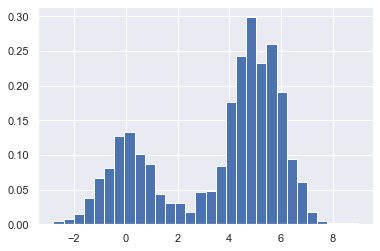

In [3]:
# plt.hist()
# density=True (구간의 높이가 계수를 반영하지 않고, 대신 확률 밀도를 반영하는 정규화)
hist = plt.hist(x, bins=30, density=True);

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

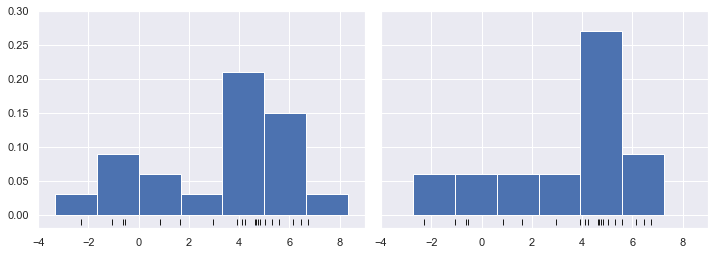

In [5]:
# 히스토그램의 문제점 - 구간의 크기와 위치 선택
x = make_data(20)
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={"xlim": (-4,9),
                                   "ylim": (-0.02, 0.3)})

fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), "|k",
               markeredgewidth=1);
    
# 두 히스토그램이 같은 데이터로 구축됏다는 사실을 짐작하지도 못했을 것

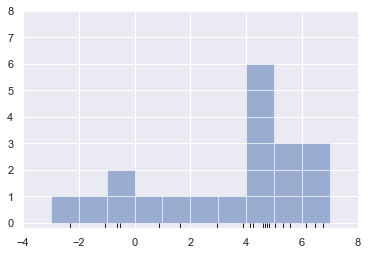

In [6]:
# 히스토그램을 블록 쌓기로 생각하기
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), "|k", markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

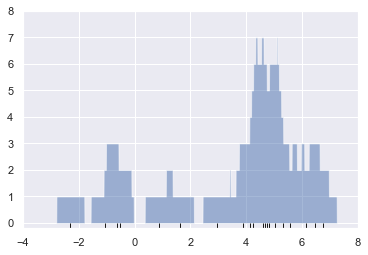

In [7]:
# 블록을 표현하는 점에 맞춰 쌓기
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), "|k", markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

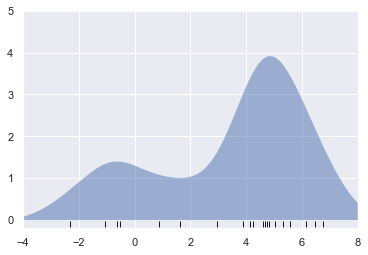

In [8]:
# 실제 데이터의 특성을 훨씬 더 견고학헤 반영
# 히스토그램을 매끄럽게 만들기
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), "|k", markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

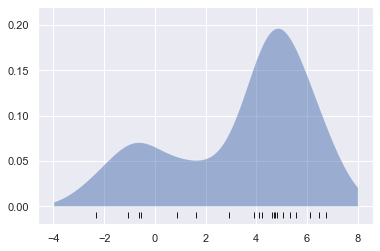

In [9]:
# 커널 밀도 추정의 실제 적용
# 자유 모수는 각 점에 위치할 분포의 모양을 지정하는 커널과 각 점에서 커널의 크기를 제어하는 커널 대역폭
# sklearn.neighbors.KernelDensity
from sklearn.neighbors import KernelDensity

# KDE 모델 인스턴스화 및 적합
kde = KernelDensity(bandwidth=1.0, kernel="gaussian")
kde.fit(x[:, None])

# score_samples는 확률 밀도의 로그를 반환함
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), "|k", markeredgewidth=1)
plt.ylim(-0.02, 0.22);

In [10]:
# 교차 검증을 통한 대역폭 선택
# 대역폭 => 너무 좊게 정하면 고분산 추정(overfit) / 너무 넓게 정하면 고편향 추정(underfit)
from sklearn.model_selection import GridSearchCV, LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel="gaussian"),
                    {"bandwidth": bandwidths},
                    cv=LeaveOneOut())

grid.fit(x[:, None]);

grid.best_params_

{'bandwidth': 1.1233240329780276}

In [11]:
# 예제: 구에 KDE 적용하기
# KDE의 가장 일반적인 예제는 점의 분포를 도표로 표현
# Basemap 툴킷 사용해 남아메리카 지도 위에 이 두 종이 관측된 위치를 플로팅

In [12]:
# 예제: 나이브하지 않은 베이즈 (Not-So-Naive-Bayes)
"""
1. 훈련 데이터를 레이블 단위로 나눈다
2. 각 집합에 대해 KDE를 적합시켜 데이터의 생성 모델을 얻는다 => P(x|y)를 계산한다
3. 훈련 데이터 집합에서 각 클래스의 예제 수로부터 클래스 사전 확률인 P(y)를 계산한다
4. 알려지지 않은 점 x에 대해 각 클래스의 사후 확률은 P(y|x) ~ P(x|y)*P(y) => 이 사후 확률을 최대화하는 클래스가
그 점에 할당될 레이블이 된다
""";